# Chapter 25: Kinetic Monte Carlo

## Learning Objectives

By the end of this lecture, you will be able to:

1. Understand the concept of Kinetic Monte Carlo (KMC) simulations.
2. Implement a simple KMC simulation in Python.
3. Apply KMC simulations to model the dynamics of a system.

## Introduction to Kinetic Monte Carlo

Phenomena such as diffusion, nucleation of a new phase, structural transformations, and chemical reactions often involve processes that occur over timescales much longer than those accessible via molecular dynamics (MD) simulations. MD simulations are limited by computational resources, making it challenging to simulate processes that occur over milliseconds or longer. Despite their extended timescales, these processes are kinetic and time-dependent.

A common aspect of these processes is that they proceed through transitions between various configurations or states, each occurring with a certain frequency. These frequencies determine the time evolution of the entire process. However, they are not outcomes of the kinetic Monte Carlo (KMC) method itself; rather, they must be known or calculated beforehand. This means that prior to performing a KMC simulation, the possible transitions involved in the kinetic process, along with their corresponding frequencies, must be identified and determined independently of the KMC calculation. These frequencies can be calculated using methods such as transition state theory or harmonic approximation. While they can also be calculated on the fly during the simulation, such calculations are separate from the KMC process itself.

KMC is a computational algorithm that simulates the time evolution of a system by probabilistically selecting and executing transitions based on their frequencies. To illustrate the KMC method in practice, we will apply it to model the diffusion process in a solid.

## Diffusion Studied by Kinetic Monte Carlo

We consider diffusion via the movement of vacancies in a crystal structure. For example, in the cubic structure of cerium dioxide (CeO₂), which crystallizes in this form, a vacancy can occur at one of the sites occupied by the majority atoms (oxygen in CeO₂). As shown in Figure 3, this vacancy can move to several neighboring sites, indicated by the arrows. Each such jump occurs with a specific frequency.

Vacancies facilitate atomic movement within the lattice, making them crucial for understanding diffusion mechanisms in solids. There are $N$ possible positions for the vacancy within the crystal lattice. If the vacancy is at position $i$, it can jump to $M_i$ different neighboring positions with frequencies $\nu_{ij}$, where $j$ indexes the possible destinations from position $i$. When it moves to a new position $j$, it can again jump to $M_j$ positions with frequencies $\nu_{jk}$, and so on. Thus, the diffusion process is characterized by the set of frequencies $\{ \nu_{ij} \}$, forming an $N \times N$ matrix where each element represents the frequency of a jump from position $i$ to position $j$. Note that some of these frequencies may be zero if a direct jump from $i$ to $j$ is not possible.

The probability that a jump from position $i$ to position $j$ occurs is given by:

$$
p_{ij} = \frac{\nu_{ij}}{\sum_{k=1}^{N} \nu_{ik}}
$$

Here, $\sum_{k=1}^{N} \nu_{ik}$ is the total frequency of all possible jumps from position $i$. Obviously, $0 \leq p_{ij} \leq 1$, and $\sum_{j=1}^{N} p_{ij} = 1$. These probabilities are commonly referred to as **transition probabilities**, while the frequencies $\nu_{ij}$ are known as **rate constants**.

The frequencies $\nu_{ij}$ can be calculated using methods such as transition state theory or derived from experimental data. In KMC simulations, these transition probabilities are used to stochastically determine the sequence of vacancy movements over time.

In defining these jump frequencies, we assume that when the vacancy moves from position $i$ to position $j$, it completely "loses the memory" of how it arrived at state $i$. Therefore, the probability $p_{ij}$ is entirely independent of the previous jumps that led to position $i$. This property characterizes the process as a **Markov process**, which is fundamental to the KMC method.

```{figure} ceo2-vacancy-diffusion.png
---
name: ceo2-vacancy-diffusion
---
Crystal structure of cerium dioxide (CeO₂) illustrating an oxygen vacancy (highlighted). The vacancy resides on an oxygen site within the fluorite structure. The arrows indicate potential pathways for oxygen ion diffusion via vacancy migration. Axes (a, b, c) are provided for reference.
```

## Kinetic Monte Carlo Procedure

We start with a vacanccy at a position marked $i$ and select randomly a possible jump into a position $j$. This jump is then made with probability $p_{ij}$. To do this we generate a random number $\xi$ such that $0 \leq \xi < 1$ and make the jump $i \rightarrow j$ if $p_{ij} \geq \xi$. However, if $p_{ij} < \xi$ we do not make any jump and repeat the process starting again by selecting randomly another possible jump.. After a jump occurred we start with a new vacancy position that is associated with new jump frequencies (new rate constants) and the process is repeated. In this way the vacancy travels and attains various positions but to determine the rate at which it moves we have to associate a time with each step of this random walk.

If the vacancy is at a site $i$ then the frequency $\nu_\text{tot}^i$ with which it will leave the site $i$ is equal to the sum of the frequencies of all possible jumps away from the site $i$:

$$
\nu_\text{tot}^i = \sum_{k=1}^{M_i} \nu_{ik}
$$

Hence the time the vacancy stays at the site $i$ is

$$
t_i = \frac{1}{\nu_\text{tot}^i}
$$

In this way we have associated with every vacancy position $i$ the time $t_i$ during which the vacancy waits at this position. This time is usually dominated by one of the frequencies that is much higher than all the other frequencies. During the KMC process we associate with every state $i$ into which the vacancy got during the process, the time $t_i$ during which the vacancy remains at the position $i$, determined by the previous equation. The time associated with the process consisting of $K$ steps of the KMC is then

$$
\Delta t^{(K)} = \sum_{k \text{ corresponding to all states attained}} t_k
$$

## Transition (Reaction) Rate Theory

We investigate a process during which the potential energy of a system varies as depicted in the figure below. The initial and final states are **metastable**, corresponding to minima in the potential energy (or enthalpy, if external forces are performing work). Between these states, the energy rises to a maximum at an intermediate stage, representing the **activated state** or **transition state**.

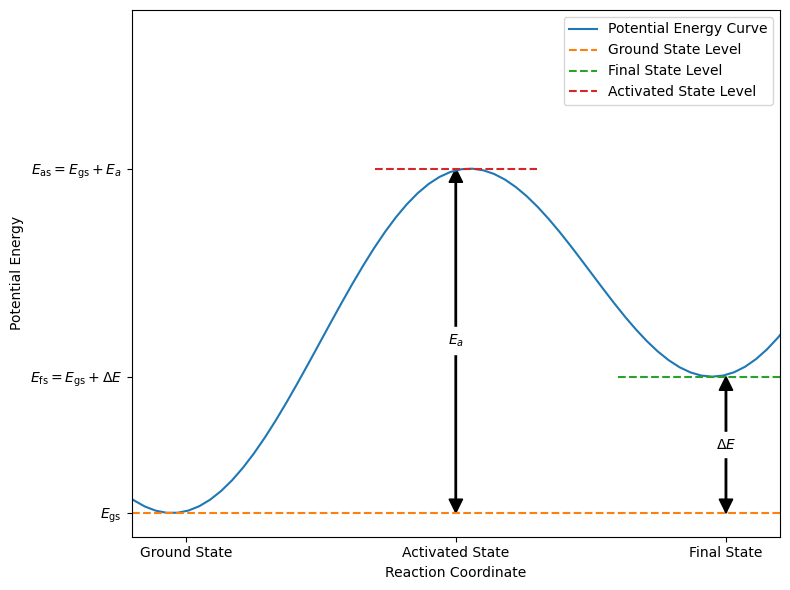

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def add_double_arrow(x, y_min, y_max, arrow_length_offset=0, head_width=0.0125, head_length=0.05, color='black'):
    """
    Add a double-sided arrow to a plot.

    Parameters:
        x (float): The x-coordinate of the arrow base.
        y_min (float): The starting y-coordinate (bottom) of the arrow.
        y_max (float): The ending y-coordinate (top) of the arrow.
        arrow_length_offset (float): Adjustment to the arrow length (positive to make shorter).
        head_width (float): Width of the arrowhead.
        head_length (float): Length of the arrowhead.
        color (str): Color of the arrows.
    """
    arrow_length = y_max - y_min - arrow_length_offset
    
    # Downward arrow
    plt.arrow(x, y_min, 0, arrow_length, head_width=head_width, head_length=head_length, fc=color, ec=color)
    
    # Upward arrow
    plt.arrow(x, y_min + arrow_length, 0, -arrow_length + arrow_length_offset, head_width=head_width, head_length=head_length, fc=color, ec=color)

# Generate data for the potential energy curve
x = np.linspace(0, 1, 100)
y = -np.sin(2 * np.pi * x) ** 2 + x

# Define key points for the ground, activated, and final states
x_gs, x_as, x_fs = 0.25, 0.5, 0.75
y_gs = np.min(y)
y_as = np.max(y[y.shape[0] // 4:3 * y.shape[0] // 4])
y_fs = np.min(y[y.shape[0] // 2:])

# Plot the potential energy curve
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Potential Energy Curve')
plt.xlabel('Reaction Coordinate')
plt.ylabel('Potential Energy')
plt.xlim(0.2, 0.8)
plt.xticks([x_gs, x_as, x_fs], ['Ground State', 'Activated State', 'Final State'])
plt.yticks([y_gs, y_as, y_fs], ['$E_\\text{gs}$', '$E_\\text{as} = E_\\text{gs} + E_a$', '$E_\\text{fs} = E_\\text{gs} + \\Delta E$'])

# Add dashed lines for energy levels
plt.axhline(y=y_gs, color='C1', linestyle='--', label='Ground State Level')
plt.axhline(y=y_fs, xmin=0.75, xmax=1, color='C2', linestyle='--', label='Final State Level')
plt.axhline(y=y_as, xmin=0.375, xmax=0.625, color='C3', linestyle='--', label='Activated State Level')

# Add double-sided arrows for activation energy and reaction energy
add_double_arrow(x=0.5, y_min=y_gs, y_max=y_as, arrow_length_offset=0.05)
add_double_arrow(x=0.75, y_min=y_gs, y_max=y_fs, arrow_length_offset=0.05)

# Add text annotations for energy levels
plt.text(0.5, (y_gs + y_as) / 2, '$E_a$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.75, (y_gs + y_fs) / 2, '$\\Delta E$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))

plt.legend()
plt.tight_layout()
plt.show()

As illustrated in the figure above, the potential energy profile shows two minima separated by an energy barrier of height $E_a$. The "reaction coordinate" axis represents the pathway along which the reaction occurs, encompassing the structural changes the system undergoes during the transformation. During this process, the system temporarily acquires an amount of energy equal to $E_a$ to overcome the transition state.

**We now pose the following question: Assuming we know the reaction path and the associated energy barrier of height $E_a$, what is the frequency with which the transition from one equilibrium state to the other occurs?**

This question can be answered to a good approximation within the framework of classical transition state theory (also known as reaction rate theory), which was first thoroughly presented in the book by Glasstone, Laidler, and Eyring:

[Glasstone, S., Laidler, K. J., and Eyring, H., *The Theory of Rate Processes*, McGraw-Hill, 1941](https://wash-primo.hosted.exlibrisgroup.com/permalink/f/1kqpcd6/WUSTL_SIERRA21314618).

Transition state theory is fundamental in chemical kinetics as it allows us to predict reaction rates based on the energy barrier and temperature. It provides a method for calculating reaction rates by considering the activated complex at the top of the energy barrier. In the following sections, we summarize the main aspects of this theory and derive an expression for the reaction rate constant $k$ that depends on $E_a$ and the temperature $T$.

## Basic Assumptions of Transition State Theory

1. **Stable Initial and Final States:**
   - The reaction involves initial and final configurations that are stable states. The transition between these states occurs along a specific pathway known as the **reaction coordinate** or **reaction path**.
   - The reaction coordinate represents a path on the **potential energy surface (PES)**, which maps the energy changes as the system progresses from reactants to products.

2. **Energy Barrier and Activated State:**
   - There is an energy barrier between the initial and final states when moving along the reaction path. The most favorable path is the one with the lowest energy barrier. The point at which the energy reaches a maximum along this path is called the **activated state** or **transition state**.
   - Although the transition state represents a maximum in energy, it is a transient configuration that cannot be isolated.

3. **Quasi-Equilibrium of the Activated State:**
   - It is assumed that the system reaches a **quasi-equilibrium** where the activated state is in thermodynamic equilibrium with the initial state. This allows for the use of equilibrium thermodynamics to describe the population of the activated state.
   - In the activated state, the system vibrates in all directions perpendicular to the reaction coordinate but moves translationally along the reaction path. In contrast, the stable initial and final states have vibrational degrees of freedom in all directions, including along the reaction coordinate.
   - The validity of these assumptions depends on the specific reaction mechanism. These are approximations, and experimental observations ultimately determine whether the conclusions drawn from the theory are accurate. In cases where quantum tunneling or non-equilibrium dynamics play a significant role, the assumptions may not hold.

## Main Results of Transition State Theory

In transition state theory, the reaction rate (or frequency of activations) is given by:

$$
\nu = \nu_0 \exp\left(-\frac{E_a}{k_\text{B} T}\right)
$$

where:

- $\nu$ is the reaction rate or frequency of successful transitions.
- $\nu_0$ is the **pre-exponential factor** or **attempt frequency**, representing the frequency of attempts to overcome the energy barrier.
- $E_a$ is the activation energy—the height of the energy barrier between the initial and final states.
- $k_\text{B}$ is the Boltzmann constant.
- $T$ is the absolute temperature.

Because of the exponential dependence on the activation energy $E_a$, the actual reaction frequency $\nu$ is much smaller than the attempt frequency $\nu_0$; the difference between these two frequencies can span several orders of magnitude.

```{tip}
To test whether a process is well described by transition state theory, you can produce an **Arrhenius plot**. Plot the logarithm of a quantity proportional to the reaction rate (e.g., $\ln \nu$ or $\ln k$) versus the inverse of the temperature $1/T$. If the process follows transition state theory, the plot should be a straight line, indicating an exponential dependence on $E_a$.
```

## Application of the Kinetic Monte Carlo to Oxygen Vacancy Diffusion in CeO₂

We will now apply the KMC method to model the diffusion of oxygen vacancies in CeO₂. The vacancy can move to neighboring sites with specific frequencies, and we will simulate the time evolution of the system by stochastically selecting and executing these jumps. The frequencies of the jumps are determined by the transition probabilities, which are calculated based on the rate constants.

In this example, we will consider a cubic lattice with vacancies that can move to neighboring sites in three dimensions. We will define the lattice as a 3D array, where each site can be occupied by an oxygen atom or a vacancy. The vacancy will move to neighboring sites with specific frequencies, and we will simulate the diffusion process using the KMC method.

Let's start by defining the cubic lattice parameters.

In [2]:
# Define the cubic lattice parameters
lattice_size = 10  # 10x10x10 lattice
num_steps = 10000  # Number of KMC steps
temperature = 1000  # Temperature in Kelvin
activation_energy = 1.0  # Activation energy in eV
attempt_frequency = 1e13  # Attempt frequency in Hz
boltzmann_constant = 8.617333262e-5  # Boltzmann constant in eV/K

Next, we will precompute the rate constants for the vacancy jumps between neighboring sites. We will assume that the vacancy can move to the six neighboring sites in 3D space with equal frequencies. The rate constants will be calculated based on the activation energy and temperature.

In [3]:
# Precompute rate constant
rate_constant = attempt_frequency * np.exp(-activation_energy / (boltzmann_constant * temperature))
print(f"Rate constant: {rate_constant:.2e} Hz")

Rate constant: 9.12e+07 Hz


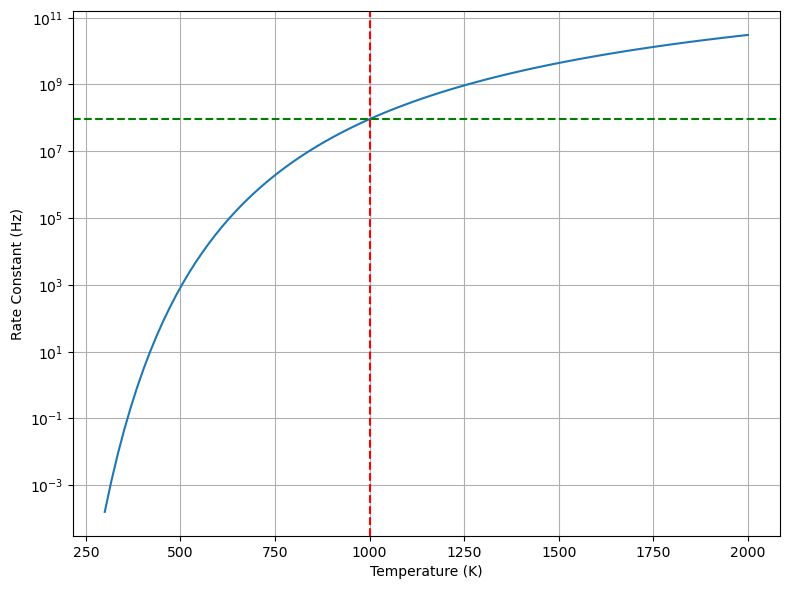

In [4]:
# Plot the rate constant as a function of temperature
temperatures = np.linspace(300, 2000, 100)
rate_constants = attempt_frequency * np.exp(-activation_energy / (boltzmann_constant * temperatures))

plt.figure(figsize=(8, 6))
plt.plot(temperatures, rate_constants)
plt.axvline(x=temperature, color='red', linestyle='--')
plt.axhline(y=rate_constant, color='green', linestyle='--')
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant (Hz)')
plt.tight_layout()
plt.grid(True)
plt.show()

Now, we will initialize the lattice with a single vacancy at the center and simulate the diffusion process using the KMC method. We will randomly select a neighboring site to move the vacancy to based on the transition probabilities calculated from the rate constants.

In [5]:
# Initialize the lattice with a single vacancy
lattice = np.zeros((lattice_size, lattice_size, lattice_size), dtype=int)
vacancy_position = [lattice_size // 2] * 3  # Start at the center of the lattice
# vacancy_position = [0, 0, 0]
# vacancy_position = [lattice_size - 1] * 3
lattice[tuple(vacancy_position)] = 1  # Mark the vacancy position

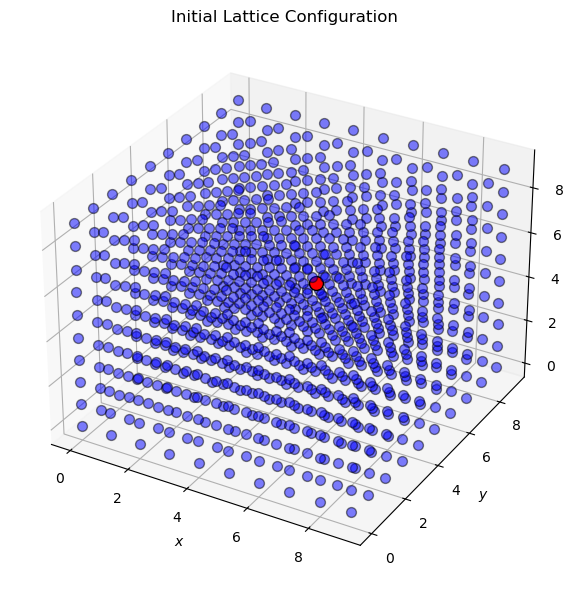

In [6]:
# Plot the initial lattice configuration
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the lattice sites
for i in range(lattice_size):
    for j in range(lattice_size):
        for k in range(lattice_size):
            if lattice[i, j, k] == 1:
                ax.scatter(i, j, k, color='red', s=100, edgecolors='black')
            else:
                ax.scatter(i, j, k, color='blue', s=50, edgecolors='black', alpha=0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Initial Lattice Configuration')
plt.tight_layout()
plt.show()

Next, we will define the neighbor offsets for a cubic lattice, where the vacancy can move to six neighboring sites in 3D space.

In [7]:
# Define neighbor offsets for a cubic lattice (6 neighbors)
neighbor_offsets = [
    (-1, 0, 0), (1, 0, 0),  # +/- x direction
    (0, -1, 0), (0, 1, 0),  # +/- y direction
    (0, 0, -1), (0, 0, 1)   # +/- z direction
]

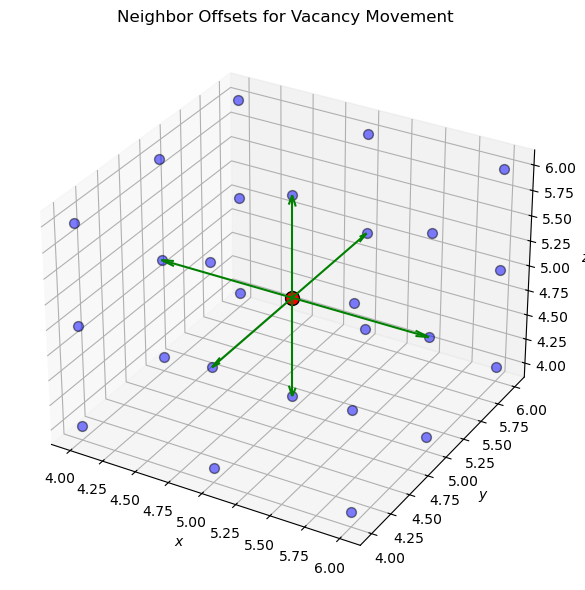

In [8]:
# Plot the neighbor offsets in 3D space as arrows from the vacancy position (center) to the neighbors (6 directions)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot a subset of the lattice sites
for i in range(lattice_size // 2 - 1, lattice_size // 2 + 2):
    for j in range(lattice_size // 2 - 1, lattice_size // 2 + 2):
        for k in range(lattice_size // 2 - 1, lattice_size // 2 + 2):
            if (i, j, k) == tuple(vacancy_position):
                ax.scatter(i, j, k, color='red', s=100, edgecolors='black')
            else:
                ax.scatter(i, j, k, color='blue', s=50, edgecolors='black', alpha=0.5)

# Plot the neighbor offsets as arrows
for offset in neighbor_offsets:
    ax.quiver(vacancy_position[0], vacancy_position[1], vacancy_position[2], offset[0], offset[1], offset[2], color='green', arrow_length_ratio=0.1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Neighbor Offsets for Vacancy Movement')
plt.tight_layout()
plt.show()

Now, we will keep track of the vacancy position and time during the KMC simulation. We will randomly select a neighboring site to move the vacancy to based on the transition probabilities calculated from the rate constants. The simulation will proceed for a specified number of steps.

In [9]:
# Keep track of the vacancy position and time
vacancy_positions = [tuple(vacancy_position)]
time = 0
time_steps = [time]

Next, we will perform the KMC simulation by randomly selecting a neighboring site to move the vacancy to based on the transition probabilities. We will update the vacancy position and time for each step.

In [10]:
# Run the KMC simulation
np.random.seed(42)  # Set random seed for reproducibility
for step in range(num_steps):
    while True:
        # Determine possible moves
        possible_moves = []
        for offset in neighbor_offsets:
            # Calculate the neighbor position (wrap around for periodic boundary conditions)
            neighbor = [
                (vacancy_position[i] + offset[i]) % lattice_size
                for i in range(3)
            ]
            possible_moves.append(neighbor)
        
        # Assign probabilities to each move (uniform here)
        probabilities = [rate_constant for _ in possible_moves]
        probabilities /= np.sum(probabilities)
        
        # Randomly select a possible move
        chosen_move_idx = np.random.choice(len(possible_moves))
        new_position = possible_moves[chosen_move_idx]

        # Generate a random number for acceptance
        xi = np.random.random()

        # Check the acceptance criterion
        if xi < probabilities[chosen_move_idx]:
            # Move is accepted, exit the loop
            break

    # Update the lattice and the vacancy position
    lattice[tuple(vacancy_position)] = 0
    lattice[tuple(new_position)] = 1
    vacancy_position = new_position
    vacancy_positions.append(tuple(vacancy_position))

    # Update time
    total_rate = np.sum([rate_constant for _ in possible_moves])
    time += -np.log(np.random.random()) / total_rate
    time_steps.append(time)

print(f"Total simulation time: {time:.2e} s")

Total simulation time: 1.84e-05 s


In [11]:
# Convert the vacancy positions to a list of ASE atoms for visualization
from ase import Atoms
from ase.visualize import view

list_atoms = []
for position in vacancy_positions:
    # Create a list of chemical symbols for the lattice sites
    chemical_symbols = []
    for i in range(lattice_size):
        for j in range(lattice_size):
            for k in range(lattice_size):
                if (i, j, k) == position:
                    chemical_symbols.append('F')  # Vacancy
                else:
                    chemical_symbols.append('O')  # Oxygen atom

    # Create an ASE Atoms object for the lattice configuration
    atoms = Atoms(chemical_symbols, positions=[(i, j, k) for i in range(lattice_size) for j in range(lattice_size) for k in range(lattice_size)], pbc=True, cell=[lattice_size, lattice_size, lattice_size])
    list_atoms.append(atoms)

# Write the lattice configurations to a trajectory file for visualization
from ase.io import write
write('vacancy_diffusion.extxyz', list_atoms)

```{figure} vacancy_diffusion.png
---
name: vacancy-diffusion
---
Visualization of the vacancy diffusion process in a cubic lattice. The vacancy (highlighted in blue) moves to neighboring sites over time, simulating the diffusion process. The trajectory lines indicate the path taken by the vacancy during the simulation.
```

## Diffusion Constant

The diffusion constant of the vacancy, $D_v$, can now be determined using the Einstein formula

$$
D_v = \lim_{\tau \to \infty} \frac{1}{6 \tau} \langle \left[ r(\tau) - r(0) \right]^2 \rangle
$$

expressed as

$$
D_v = \lim_{K \to \infty} \frac{1}{6 \Delta t^{(K)}} \langle \left[ r(\Delta t^{(K)}) - r(0) \right]^2 \rangle
$$

where $r(\Delta t^{(K)})$ is the position of the vacancy after $K$ steps and $r(0)$ the starting position. **Averaging has to be taken over a large number of KMC paths that start with different original positions of the vacancy.**

## Summary

In this lecture, we introduced the concept of KMC simulations and applied it to model the diffusion of oxygen vacancies in a solid. We precomputed the rate constants for vacancy jumps between neighboring sites and simulated the time evolution of the system by stochastically selecting and executing these jumps. The KMC method allowed us to model the dynamics of the system over time and observe the diffusion process in action.